In [ ]:
# Intalacion de librerias necesarias y descarga de archivos necesarios
!pip install pandas numpy matplotlib seaborn sklearn tensorflow gensim

!git init
!git remote add origin https://github.com/dsierra26/proyecto_fundamentos_DL.git
!git config core.sparseCheckout true

!echo "otros/*" > .git/info/sparse-checkout
!echo "!otros/*.h5" >> .git/info/sparse-checkout

!git pull origin main

## 1. Introducción

En esta iteración del modelo, se introduce el uso de capas bidireccionales en las LSTM. Además, se ha mantiene el número de épocas de entrenamiento a 20, buscando explorar el impacto de un entrenamiento más prolongado en el desempeño del modelo.

La arquitectura vuelve al embedding preentrenado basado en Word2Vec (con `sg=0`) como entrada, seguido de dos capas LSTM bidireccionales con unidades de 128 y 64 respectivamente, intercaladas con capas de Dropout para prevenir el sobreajuste. La capa densa final genera la salida de predicción con una activación lineal, ya que el objetivo sigue siendo una tarea de regresión.

## 2. Carga de Datos

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from IPython.display import Image, display

# Estilo de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Cargar los datos
df = pd.read_csv('otros/data/clean_subset.csv')
df.info()

2024-11-19 20:35:59.697617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732048559.715338   98883 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732048559.720779   98883 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 20:35:59.739804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hadm_id  1000 non-null   int64 
 1   text     1000 non-null   object
 2   los      1000 non-null   int64 
 3   blos     1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


In [2]:
# Dividir los datos en Train y Test
X = df['text']
y = df['los']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño de entrenamiento: {X_train.shape}")
print(f"Tamaño de prueba: {X_test.shape}")

Tamaño de entrenamiento: (800,)
Tamaño de prueba: (200,)


## 3. Preprocesamiento de Datos

In [3]:
# Tokenizar el conjunto de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convertir `X_train` y `X_test` en secuencias de tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Obtener el índice de palabras del tokenizer
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [4]:
# Seleccion de la longitud maxima para realizar el padding
sequence_lengths = [len(seq) for seq in X_train_seq]
max_sequence_length = int(np.percentile(sequence_lengths, 95))
# En este caso se define una longitud que abarque al menos el 95% de las historias clinicas para ek cinjunto de datos originales 
# el valor fue de max_secuence_lenhth = 1908
 
# Rellenar o truncar secuencias en ambos conjuntos
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

##  4. Entrenamiento del Modelo Word2Vec

In [5]:
# Crear listas de listas de palabras para entrenar Word2Vec
sentences = [text.split() for text in X_train]

# Entrenar el modelo Word2Vec
embedding_dim = 100
word2vec_model = Word2Vec(sentences=sentences, vector_size=embedding_dim, window=5, min_count=1)

# Generar la matriz para alamcenar los pesos
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

## 5. Construcción y Entrenamiento del Modelo

In [6]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

/home/dsierra/miniconda3/envs/mimic/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1732048565.592143   98883 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11549 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:84:00.0, compute capability: 6.1


In [7]:
model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/20


I0000 00:00:1732048570.018619  101620 cuda_dnn.cc:529] Loaded cuDNN version 90300


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - loss: 103.7839 - mae: 4.8411 - val_loss: 37.6690 - val_mae: 3.7875
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - loss: 72.6182 - mae: 3.8808 - val_loss: 38.1629 - val_mae: 4.0854
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 63.3722 - mae: 4.3121 - val_loss: 38.2677 - val_mae: 3.8827
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 102.7770 - mae: 4.7169 - val_loss: 38.7192 - val_mae: 3.8833
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 67.6463 - mae: 4.2189 - val_loss: 38.7206 - val_mae: 3.9351
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - loss: 93.3663 - mae: 4.6274 - val_loss: 38.8438 - val_mae: 3.9859
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - loss: 56.3924 - mae: 4.0194 - val_loss: 39.2661 - val_mae: 3.8936
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 55.5054 - mae: 4.1433 - val_loss: 38.9520 - val_mae: 4.0460
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/s

## 6. Evaluación del Modelo

In [8]:
# Predicción sobre el conjunto de prueba
y_pred = model.predict(X_test_padded)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Imprimimos las métricas obtenidas
print(f"MSE: {mse}")  # Error cuadrático medio
print(f"MAE: {mae}")  # Error absoluto medio
print(f"RMSE: {rmse}")  # Raíz del error cuadrático medio
print(f"R²: {r2}")  # Coeficiente de determinación R²

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
MSE: 37.40500346001125
MAE: 3.9107681465148927
RMSE: 6.115963003486144
R²: 0.023132741451263428


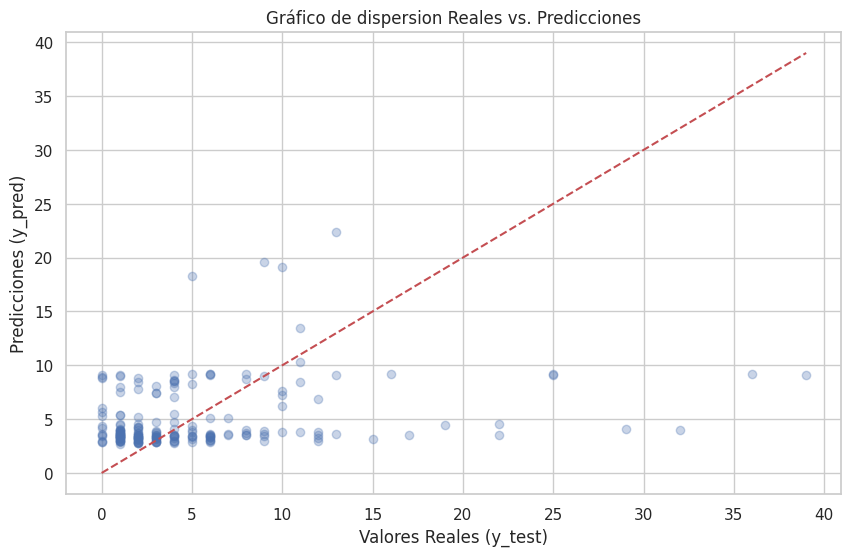

In [9]:
# Gráfico de Dispersión: Predicciones vs. Valores Reales

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Gráfico de dispersion Reales vs. Predicciones")
plt.show()

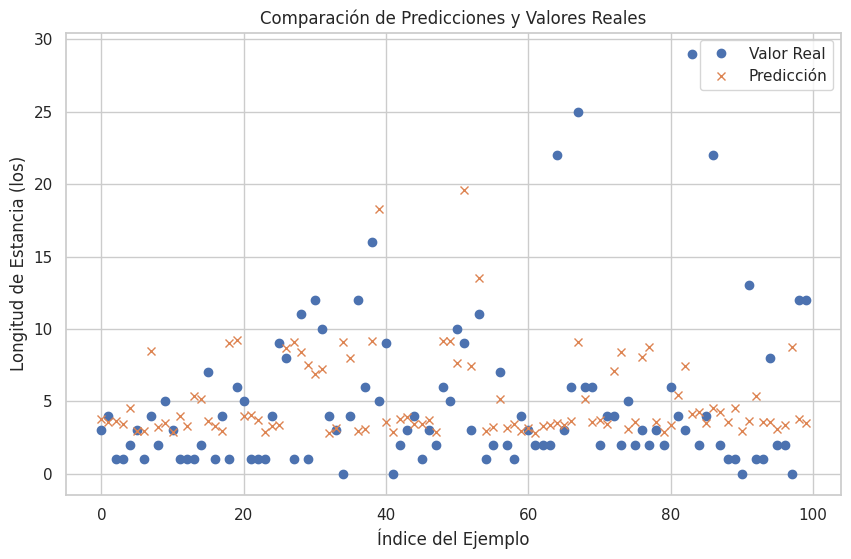

In [10]:
# Predicciones y Valores Reales

plt.figure()
plt.plot(range(100), y_test[:100], marker='o', linestyle='', label="Valor Real")
plt.plot(range(100), y_pred[:100], marker='x', linestyle='', label="Predicción")
plt.xlabel("Índice del Ejemplo")
plt.ylabel("Longitud de Estancia (los)")
plt.legend()
plt.title("Comparación de Predicciones y Valores Reales")
plt.show()

## 7. Resultados sobre el Conjunto de Datos original

En esta sección se presentan los resultados obtenidos al evaluar el modelo base de regresión entrenado sobre los datos originales, utilizando los embeddings con **sg=0** y **20 epochs**, sobre el conjunto de datos de testeo original. A continuación se muestran las métricas obtenidas:

- **MSE (Error Cuadrático Medio)**: 19.53
- **MAE (Error Absoluto Medio)**: 2.05
- **RMSE (Raíz del Error Cuadrático Medio)**: 4.41
- **R² (Coeficiente de Determinación)**: 0.64

### Gráfico de dispersion Reales vs. Predicciones

![Gráfico de dispersion Reales vs. Predicciones](otros/scater_plot_reg_03.png)


### Comparación de Predicciones y Valores Reales

![Comparación de Predicciones y Valores Reales](otros/comparison_plot_reg_03.png)

In [ ]:
display(Image(filename="otros/scater_plot_reg_03.png"))
display(Image(filename="otros/comparison_plot_reg_03.png"))

In [ ]:
# Cargar el modelo entrenado sobre los datos originales las lineas estan comentadas porque los modelos son muy pesados para
# cargarlos en el colab, pero el archivo con el modelo se encuentra en el repositorio

#model = load_model('otros/modelo_regresion_03.h5')
#model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1908, 100)      │    80,658,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1908, 256)      │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1908, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,057,877 (309.21 MB)

 Trainable params: 398,977 (1.52 MB)

 Non-trainable params: 80,658,900 (307.69 MB)